### Problem 3 - RANSAC
##### When data is scattered, the least squares method to fit a curve might not be the best choice. In this problem, you are given data for health insurance costs based on the person’s age. There are other fields as well, but you have to fit a line only for age and insurance cost data.

###### The data is stored in the file - 'dataset.csv'

>> Read and plot csv file

Text(0.5, 1.0, 'Dataset')

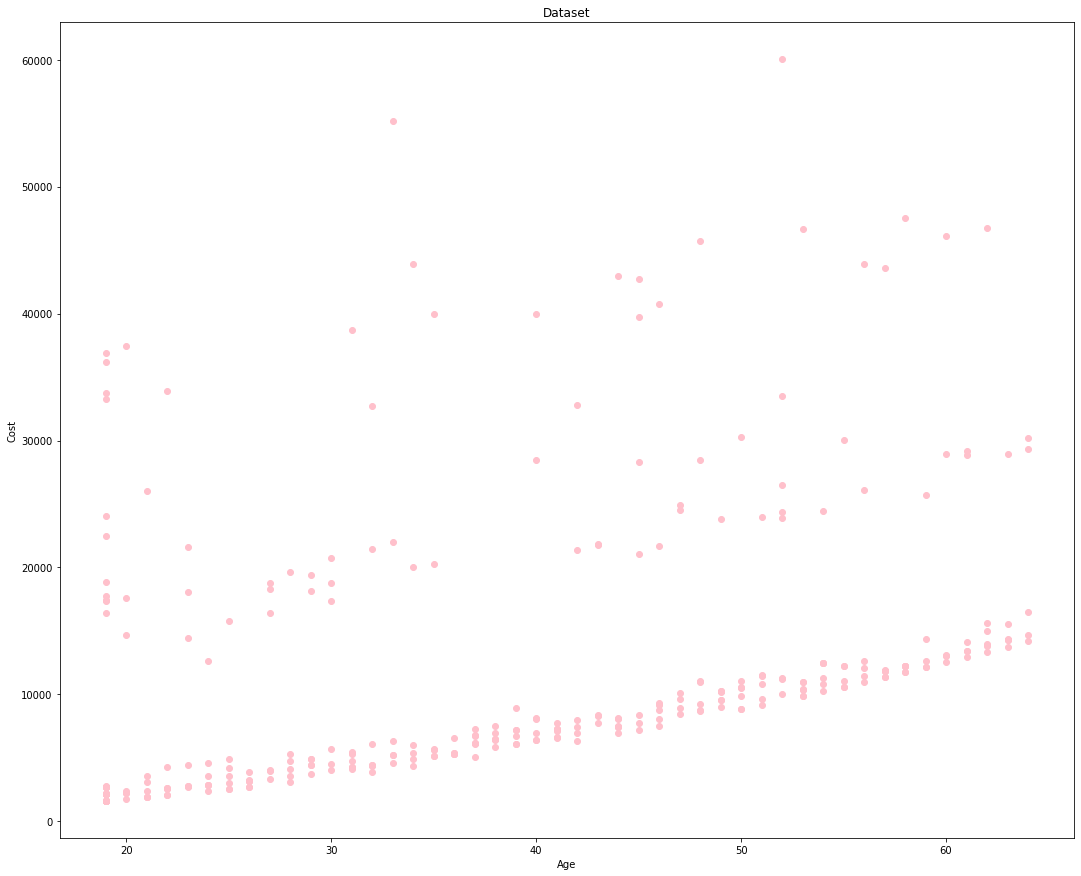

In [25]:
import csv
age = []
cost = []
with open('dataset.csv', 'r' ) as theFile:
    reader = csv.DictReader(theFile)
    for line in reader:
        age.append(float(line['age']))
        cost.append(float(line['charges']))

import matplotlib.pyplot as plot

fig1 = plot.figure(figsize=(40,15))
plot.subplot(121)
plot.xlabel('Age')
plot.ylabel('Cost')
plot.scatter(age,cost,c ="pink")
plot.title('Dataset')

##### 1. Compute the covariance matrix (from scratch) and find its eigenvalues and eigenvectors. 
###### Plot the eigenvectors on the same graph as the data.

In [32]:
# Calculate mean age and cost
mean_age = sum(age) / len(age)
mean_cost = sum(cost) / len(cost)
var_age = 0.0
var_cost = 0.0
covar_ = 0.0
covar_cost = 0.0
for i in range(len(age)) :
    var_age += (age[i]-mean_age)**2
    var_cost += (cost[i]-mean_cost)**2
    covar_ += (age[i]-mean_age)*(cost[i]-mean_cost)
var_age/=len(age)
var_cost/=len(age)
covar_/=len(age)

print('Mean age: ',mean_age, ', Mean cost: ',mean_cost, ', Variance age: ',var_age, ', Variance cost: ',var_cost, ', Covariance: ',covar_)

Mean age:  39.19692307692308 , Mean cost:  12417.575373969228 , Variance age:  196.84122130177533 , Variance cost:  122218100.00298595 , Covariance:  52371.79820041833
